# Data Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import re, string
import nltk
import spacy
import pickle
from tqdm import tqdm
from bs4 import BeautifulSoup
from prettytable import PrettyTable  # To print in a table

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Loading data from disk
data = pickle.load(open('data_conv.pkl', 'rb'))

In [ ]:
data.shape

(794299, 6)

## Data Preprocessing

### Plotting Functions

In [ ]:
# Utility function

#---------------------------------------------------------------
# Basic stats
#---------------------------------------------------------------
def basic_statistics (columns, data=data):
    """
    Return basic statistics like min, max and others
    """
    x = PrettyTable()
    header = ["stats"] + columns
    result = {'minimum':[], 'maximum':[], 'mean':[], 'median':[], '25th per':[],
              '50th per':[], '75th per':[], '90th per':[], '95th per':[], '99th per':[]}

    for col in columns:
        col_val = data[col].values
        # Getting stats for the column
        result['minimum'].append(np.round(col_val.min(),2))
        result['maximum'].append(np.round(col_val.max(),2))
        result['mean'].append(np.round(np.mean(col_val),2))
        result['median'].append(np.round(np.median(col_val),2))
        for p in [25, 50, 75, 90, 95, 99]:
            result[str(p)+"th per"].append(np.round(np.percentile(col_val, p),2))
    
    # Printing results in a table
    x.field_names = header
    for tup in result.items():
        x.add_row([tup[0]]+tup[1])
    print(x)



#---------------------------------------------------------------
# Plotting Series
#---------------------------------------------------------------
def plot_func(columns, xlabel, ylabel, title, data=data, header=["Question", "Answer"]):
    """
    Plots pdf and boxplot on the given data
    """
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(18, 6))
    
    # Adding subplots
    pdf = fig.add_subplot(1,2,1)
    box = fig.add_subplot(1,2,2)
    
    # pdf/distplot
    pdf.set(title=title, xlabel=xlabel, ylabel=ylabel)
    for col in columns:
        sns.distplot(data[col].values, hist=True, rug=True, ax=pdf, label=col)
    pdf.legend()
    
    # boxplot
    box.set(title=title, ylabel=xlabel)
    sns.boxplot(data=data[columns], ax=box, orient='v')
    box.set_xticklabels(columns)
    
    plt.plot()

### Utility Functions

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

That data has lots of emojis, we will remove the emojis

In [ ]:
#Refer: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)

In [ ]:
# Refer : https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

Emoticons are emojis with real charecters, like :) :D :p and so on. With the help of below link we found out a list of emoticons, need to clean these.

In [ ]:
def remove_emoticons(text):
    " Remove emoticons from text"
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

In [ ]:
def clean_text(text):
    """
    This function clean the given data and preprocess it.
    """
    # Lower casting
    text = text.lower()

    # Remove all the mentions (words starting with '@')
    text = re.sub(r"@\S+", '', text)

    # Remove URL
    text = re.sub(r"http\S+", "", text)

    # Remove html tags
    text = BeautifulSoup(text, 'lxml').get_text()

    # Decontracted
    text = decontractions(text)

    # Remove emoji
    text = remove_emoji(text)

    # Remove emoticons
    text = remove_emoticons(text)

    # Remove words with digit
    text = re.sub("\S*\d\S*", "", text).strip()

    # Remove any special charecters and punctuations
    text = re.sub("[^A-Za-z\n]", " ", text)

    # Remove more than 1 space
    text = " ".join(text.split())

    return text

In [ ]:
# To see the progress bar in pandas apply
tqdm.pandas()

### Preprocessing Text Data

In [ ]:
data.shape

(794299, 7)

In [ ]:
# Preprocessing questions
data['clean_question'] = data['question'].progress_apply(clean_text)

100%|██████████| 794299/794299 [06:59<00:00, 1893.22it/s]


In [ ]:
data[['question', 'clean_question']].head()

,question,clean_question
251468,@122172 need help,need help
700147,@115911 @TMobileHelp @115725 @ATT @115911 why ...,why did you stop allowing conference calling w...
185503,Oh course @115955 WiFi would go down on Thanks...,oh course wifi would go down on thanksgiving
870280,When the vinaigrette from @ChipotleTweets is 1...,when the vinaigrette from is saltier than it i...
424733,PISSED OFF THAT @115888 FUCKING CHARGED ME FUL...,pissed off that fucking charged me full price ...


In [ ]:
# Preprocessing answers
data['clean_answer'] = data['answer'].progress_apply(clean_text)

100%|██████████| 794299/794299 [06:56<00:00, 1906.74it/s]


In [ ]:
data[['answer', 'clean_answer']].head()

,answer,clean_answer
251468,@340004 Hi. What's your platform &amp; which c...,hi what is your platform which contract are yo...
700147,@693750 Hey thanks so much for reaching out! Y...,hey thanks so much for reaching out you are a ...
185503,@284249 I'm sorry to hear about the service is...,i am sorry to hear about the service issue i c...
870280,@820001 Sorry to hear that. Did you let a mana...,sorry to hear that did you let a manager know ...
424733,@476849 Hi! We've just sent a DM your way. Let...,hi we have just sent a dm your way let is carr...


## Saving Data to disk

In [ ]:
pickle.dump(data, open('clean_conv.pkl', 'wb'))

In [ ]:
# Loading Data
data = pickle.load(open("clean_conv.pkl", "rb"))

In [ ]:
data.shape

(794299, 8)

In [ ]:
pickle.dump(imp_param_dict, open('imp_param_dict.pkl', 'wb'))

## No of words in text

After cleaning the data we will again check for the no of words present in data. From this we can decide what max_len to keep and use for training

In [ ]:
data['qsn_len'] = data['clean_question'].apply(lambda x: len(x.split()))
data['ans_len'] = data['clean_answer'].apply(lambda x: len(x.split()))

In [ ]:
data['ans_len'] = data['clean_answer'].apply(lambda x: len(x.split()))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
basic_statistics(["qsn_len", "ans_len"])

+----------+---------+---------+
|  stats   | qsn_len | ans_len |
+----------+---------+---------+
| minimum  |    0    |    0    |
| maximum  |    68   |    63   |
|   mean   |  18.84  |  19.69  |
|  median  |   18.0  |   19.0  |
| 25th per |   12.0  |   15.0  |
| 50th per |   18.0  |   19.0  |
| 75th per |   23.0  |   24.0  |
| 90th per |   30.0  |   28.0  |
| 95th per |   39.0  |   35.0  |
| 99th per |   49.0  |   46.0  |
+----------+---------+---------+


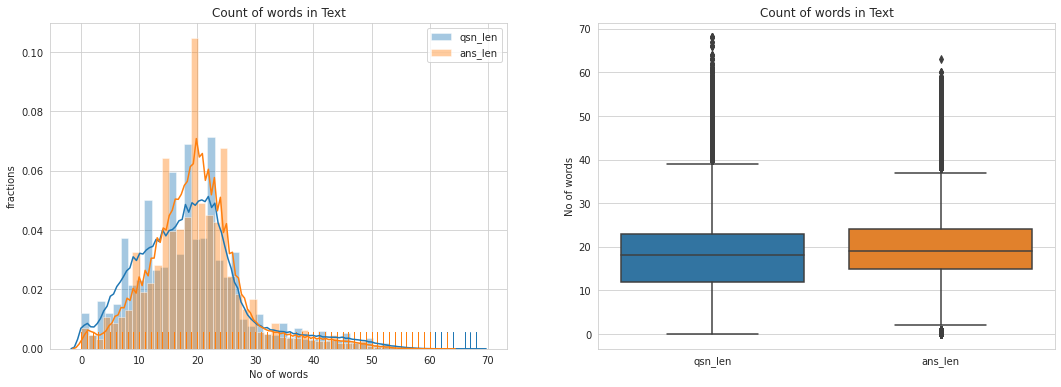

In [ ]:
plot_func(['qsn_len', 'ans_len'], 'No of words', 'fractions', 'Count of words in Text')

In [ ]:
for p in range(1,10):
    print(str(99+p/10)+"th per:",np.percentile(data['qsn_len'].values, 99+p/10))

99.1th per: 50.0
99.2th per: 50.0
99.3th per: 50.0
99.4th per: 51.0
99.5th per: 52.0
99.6th per: 52.0
99.7th per: 53.0
99.8th per: 54.0
99.9th per: 56.0


In [ ]:
for p in range(1,10):
    print(str(99+p/10)+"th per:",np.percentile(data['ans_len'].values, 99+p/10))

99.1th per: 47.0
99.2th per: 47.0
99.3th per: 48.0
99.4th per: 48.0
99.5th per: 49.0
99.6th per: 49.0
99.7th per: 50.0
99.8th per: 51.0
99.9th per: 53.0


**Observation**
1. So the maximum no of words is 68 in questions and 63 in answers.
2. Questions are having higher number of words tha answers
3. In questions words from 5-25 have highest volume and in answers its 10-25
4. We can use max_len for our text=50, which is covering over 99 percentile of values

## Common words

Looking for number of words common in both questions and answers. We can get little idea of how answer is related to question.

In [ ]:
def no_common_words(col1, col2, data=data):
    " Number of common words in both the columns "
    len_common = []
    for ind, row in tqdm(data.iterrows()):
        qsn_set = set(row[col1].split())
        ans_set = set(row[col2].split())

        common_words = qsn_set.intersection(ans_set)
        len_common.append(len(common_words))

    return len_common

In [ ]:
data['len_common'] = no_common_words('clean_question', 'clean_answer')

794299it [01:44, 7615.13it/s]


In [ ]:
basic_statistics(['len_common'])

+----------+------------+
|  stats   | len_common |
+----------+------------+
| minimum  |     0      |
| maximum  |     27     |
|   mean   |    2.1     |
|  median  |    2.0     |
| 25th per |    1.0     |
| 50th per |    2.0     |
| 75th per |    3.0     |
| 90th per |    5.0     |
| 95th per |    6.0     |
| 99th per |    8.0     |
+----------+------------+


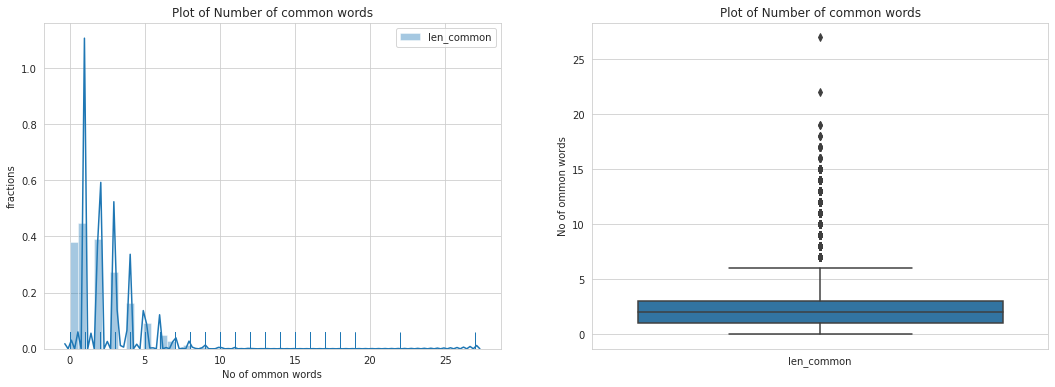

In [ ]:
plot_func(['len_common'], 'No of ommon words', 'fractions', 'Plot of Number of common words')

1. There are not much common words between questions nad answers.
2. There are lots of 0 common words that means no common words. Also 1 and 2 are also there quite a lot.
3. We have no of words 3-5 noticeably.

## Counting word frequency

In [ ]:
from collections import Counter

qsn_cnt = Counter()
for text in data['clean_question'].values:
    for word in text.split():
        qsn_cnt[word] += 1


ans_cnt = Counter()
for text in data['clean_answer'].values:
    for word in text.split():
        ans_cnt[word] += 1

In [ ]:
df_qsnFreq = pd.DataFrame({'qsn_freq':list(dict(qsn_cnt).values())})
df_ansFreq = pd.DataFrame({'ans_freq':list(dict(ans_cnt).values())})

In [ ]:
basic_statistics(['qsn_freq'], data=df_qsnFreq)
basic_statistics(['ans_freq'], data=df_ansFreq)

+----------+----------+
|  stats   | qsn_freq |
+----------+----------+
| minimum  |    1     |
| maximum  |  514519  |
|   mean   |  94.65   |
|  median  |   1.0    |
| 25th per |   1.0    |
| 50th per |   1.0    |
| 75th per |   4.0    |
| 90th per |   19.0   |
| 95th per |   67.0   |
| 99th per |  878.0   |
+----------+----------+
+----------+----------+
|  stats   | ans_freq |
+----------+----------+
| minimum  |    1     |
| maximum  |  621237  |
|   mean   |  246.54  |
|  median  |   2.0    |
| 25th per |   1.0    |
| 50th per |   2.0    |
| 75th per |   7.0    |
| 90th per |   52.0   |
| 95th per |  210.0   |
| 99th per |  1968.0  |
+----------+----------+


In [ ]:
df_qsnFreq['log_qsn_freq'] = df_qsnFreq['qsn_freq'].apply(np.log)

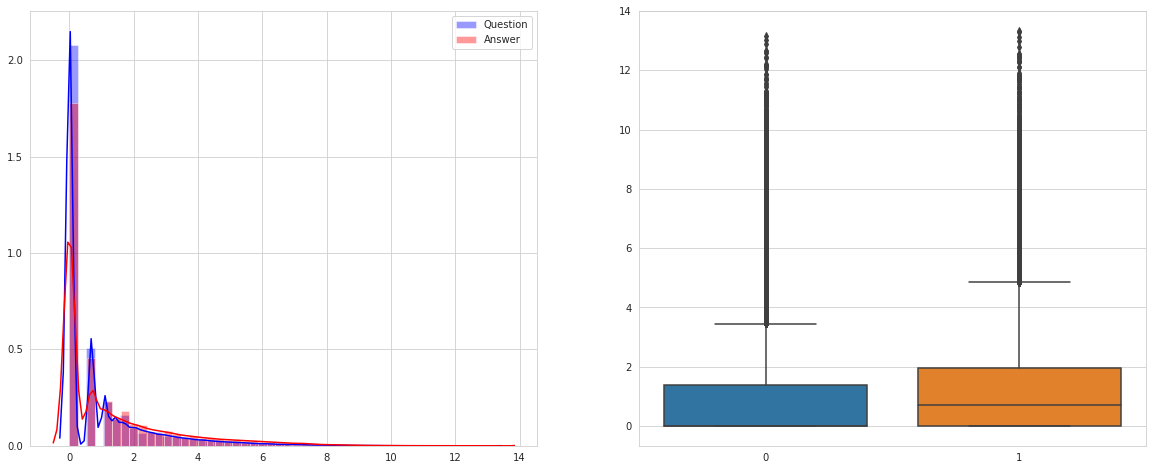

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(df_qsnFreq['qsn_freq'].apply(np.log).values, color='b', label='Question')
sns.distplot(df_ansFreq['ans_freq'].apply(np.log).values, color='r', label='Answer')
plt.legend()

plt.subplot(1,2,2)
sns.boxplot(data=[df_qsnFreq['qsn_freq'].apply(np.log).values,df_ansFreq['ans_freq'].apply(np.log).values])

plt.show()

In [ ]:
for p in range(1,10):
    print(str(99+p/10)+"th per:",np.percentile(df_qsnFreq['qsn_freq'].values, 99+p/10))

99.1th per: 1021.8029999999853
99.2th per: 1199.935999999987
99.3th per: 1409.0689999999886
99.4th per: 1686.2020000000193
99.5th per: 2074.3399999999674
99.6th per: 2771.871999999974
99.7th per: 3930.408999999956
99.8th per: 6100.35999999987
99.9th per: 12004.685000001511


In [ ]:
for p in range(1,10):
    print(str(99+p/10)+"th per:",np.percentile(df_ansFreq['ans_freq'].values, 99+p/10))

99.1th per: 2240.7430000000386
99.2th per: 2657.7919999999867
99.3th per: 3047.7949999999983
99.4th per: 3664.7400000000926
99.5th per: 4525.789999999994
99.6th per: 6302.867999999864
99.7th per: 9341.06700000009
99.8th per: 16864.534000000225
99.9th per: 45109.827000003694


In [ ]:
qsn_cnt.most_common(25)

[('i', 514519),
 ('to', 451372),
 ('the', 394938),
 ('is', 316389),
 ('my', 311443),
 ('a', 292921),
 ('and', 251604),
 ('not', 247037),
 ('for', 200171),
 ('it', 198068),
 ('on', 185933),
 ('you', 184332),
 ('in', 173243),
 ('have', 146087),
 ('of', 137228),
 ('this', 124790),
 ('can', 122276),
 ('me', 117953),
 ('with', 105877),
 ('your', 98388),
 ('do', 94067),
 ('am', 80685),
 ('but', 78798),
 ('from', 78668),
 ('that', 77509)]

In [ ]:
ans_cnt.most_common(25)

[('you', 621237),
 ('to', 597628),
 ('we', 510295),
 ('the', 439006),
 ('your', 356104),
 ('us', 281249),
 ('for', 280902),
 ('can', 267453),
 ('a', 258118),
 ('this', 246256),
 ('and', 245939),
 ('dm', 225208),
 ('is', 223482),
 ('are', 218517),
 ('please', 216798),
 ('with', 184155),
 ('i', 183277),
 ('will', 149856),
 ('help', 139943),
 ('hi', 139031),
 ('have', 135808),
 ('sorry', 133776),
 ('our', 126062),
 ('in', 124412),
 ('on', 122892)]

In [ ]:
most_cmn = {k for k,v in qsn_cnt.most_common(50)}

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(set(stop_words).intersection(most_cmn))
print(len(set(stop_words).intersection(most_cmn)))

{'have', 'am', 'to', 'at', 'when', 'so', 'up', 'a', 'of', 'can', 'why', 'has', 'be', 'just', 'do', 'was', 'with', 'me', 'my', 'but', 'no', 'all', 'how', 'you', 'the', 'been', 'it', 'in', 'for', 'an', 'what', 'is', 'this', 'not', 'they', 'and', 'that', 'will', 'i', 'are', 'on', 'your', 'now', 'out', 'from'}
45


1. Looking for most frequent words in questions.
2. After looking the words we can see that most of them are stopwords.
3. Found that top 25 words are all stopwords and among top 50 most common words total 45 words are stopwords.